<center><h1>Tang_First_Final Project</h1></center>

Name: Tang Lin
<br>
Github Username: MeLinOrDoreen
<br>
USC ID: 9012859074

Import packages

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
from matplotlib import pyplot as plt

Prepare the data

In [149]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)


Loading and pre processing the data


Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.


In [150]:
import random
import tensorflow as tf
from PIL import Image 

# def load_and_preprocess(img_loc, label):
    
#     def _inner_function(img_loc, label):
        
#         # Convert tensor to native type
#         img_loc_str = img_loc.numpy().decode('utf-8')
#         label_str = label.numpy().decode('utf-8')
        
#         img = Image.open(img_loc_str).convert('RGB')
        
        
#         return img, 1 if label_str=='frost' else 0

#     # Wrap the Python function
#     X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
#     return X, y

def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([]) # Scalar label

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

# 1. Identification of Frost in Martian HiRISE Images

## (a)

## (b)

Visualize few images

In [177]:
train_data_iterator = tf_dataset_train.as_numpy_iterator()
batch = train_data_iterator.next()

2023-12-11 14:16:37.588680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [29679]
	 [[{{node Placeholder/_1}}]]
2023-12-11 14:16:37.590047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [29679]
	 [[{{node Placeholder/_0}}]]


In [178]:
batch[0]

array([[[[0.22745098, 0.22745098, 0.22745098],
         [0.2176033 , 0.2176033 , 0.2176033 ],
         [0.20784314, 0.20784314, 0.20784314],
         ...,
         [0.21705155, 0.21705155, 0.21705155],
         [0.20001748, 0.20001748, 0.20001748],
         [0.19607843, 0.19607843, 0.19607843]],

        [[0.21563375, 0.21563375, 0.21563375],
         [0.2107319 , 0.2107319 , 0.2107319 ],
         [0.20917082, 0.20917082, 0.20917082],
         ...,
         [0.21769348, 0.21769348, 0.21769348],
         [0.20591731, 0.20591731, 0.20591731],
         [0.20395659, 0.20395659, 0.20395659]],

        [[0.18750875, 0.18750875, 0.18750875],
         [0.19245458, 0.19245458, 0.19245458],
         [0.20666926, 0.20666926, 0.20666926],
         ...,
         [0.21939957, 0.21939957, 0.21939957],
         [0.2199638 , 0.2199638 , 0.2199638 ],
         [0.2216124 , 0.2216124 , 0.2216124 ]],

        ...,

        [[0.23137255, 0.23137255, 0.23137255],
         [0.23728116, 0.23728116, 0.23728116]

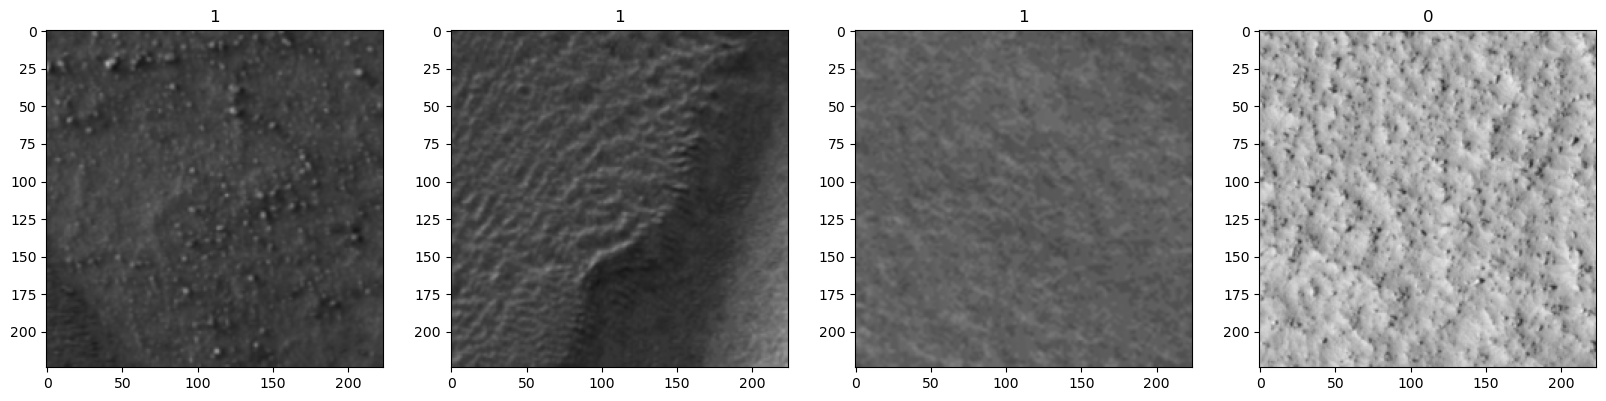

In [180]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## (c)

### (i) Data Augmentation

In [7]:
import keras
from tensorflow.keras import layers

In [21]:
# Define the data augmentation function
def augment_images(image, label):
    # Apply augmentation to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    return image, label

# Apply augmentation to the dataset using map()
augmented_train_ds = tf_dataset_train.map(augment_images)

# You can further batch and prepare the dataset for training
# batch_size = 32
# augmented_train_ds = augmented_train_ds.batch(batch_size)

# Optionally, you can prefetch the data for better performance
augmented_train_ds = augmented_train_ds.prefetch(tf.data.AUTOTUNE)

### (ii) 3-Layer CNN

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [39]:


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Add Convolutional layers
    x = Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape)(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    # Flatten the output before passing to MLP
    x = Flatten()(x)

    if num_classes == 2:
        units = 1
    else:
        units = num_classes
    
    # Add Dense layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(units, activation='softmax')(x)

    return keras.Model(inputs, outputs)


model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

In [41]:
epochs = 20

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)]


model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

hist = model.fit(
    augmented_train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=tf_dataset_val,
)

Epoch 1/20
928/928 [==============================] - 1045s 1s/step - loss: 6.2864 - acc: 0.5878 - val_loss: 10.3418 - val_acc: 0.3218
Epoch 2/20
928/928 [==============================] - 1425s 2s/step - loss: 6.2864 - acc: 0.5878 - val_loss: 10.3418 - val_acc: 0.3218
Epoch 3/20
928/928 [==============================] - 2266s 2s/step - loss: 6.2864 - acc: 0.5878 - val_loss: 10.3418 - val_acc: 0.3218
Epoch 4/20
928/928 [==============================] - 1987s 2s/step - loss: 6.2864 - acc: 0.5878 - val_loss: 10.3418 - val_acc: 0.3218
Epoch 5/20
928/928 [==============================] - 928s 1000ms/step - loss: 6.2864 - acc: 0.5878 - val_loss: 10.3418 - val_acc: 0.3218
Epoch 6/20
928/928 [==============================] - 918s 990ms/step - loss: 6.2864 - acc: 0.5878 - val_loss: 10.3418 - val_acc: 0.3218
Epoch 6: early stopping


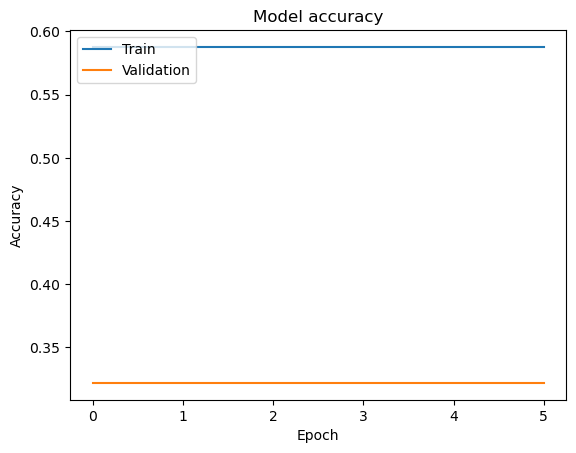

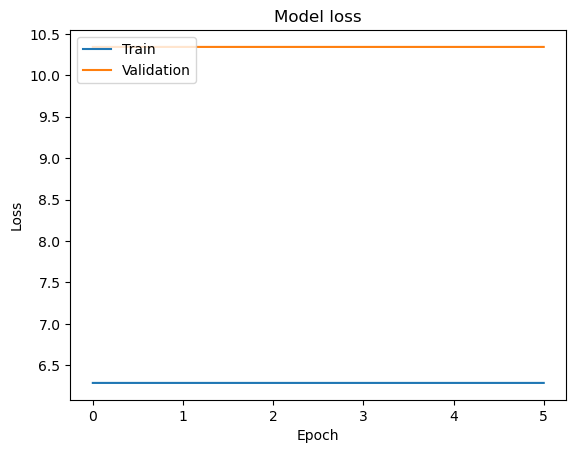

In [44]:
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### (iii) Precision, Recall, F1-Score

In [48]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [49]:
# Evaluate the model
test_loss, test_acc = model.evaluate(tf_dataset_test)
predictions = model.predict(tf_dataset_test)
y_hat = np.round(predictions)
y = np.concatenate([y for _,y in tf_dataset_test])

# Calculate Precision, Recall, and F1 score
precision = precision_score(y, y_hat, average='weighted')
recall = recall_score(y, y_hat, average='weighted')
f1 = f1_score(y, y_hat, average='weighted')

928/928 [==============================] - 314s 338ms/step


/Users/lin/anaconda3/envs/Neural_Network_py/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
print("Precision score:", precision)
print("Recall score:", recall)
print("F1-score:", f1)

Precision score: 0.34545670662794054
Recall score: 0.587755652144614
F1-score: 0.4351509706941684


## (d)

In [87]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Define the achitecture of those models

In [199]:
# Initialize pre-trained models
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers in pre-trained models
for layer in efficientnet.layers:
    layer.trainable = False
for layer in resnet.layers:
    layer.trainable = False
for layer in vgg.layers:
    layer.trainable = False

# Create model architecture using the pre-trained models
model_1 = Sequential([
    efficientnet,
    GlobalAveragePooling2D(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='softmax')  
])

model_2 = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='softmax')  
])

model_3 = Sequential([
    vgg,
    GlobalAveragePooling2D(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='softmax')  
])


In [101]:
for image, label in augmented_train_ds.take(3):  
    print(f"Image shape: {image.shape}, Label shape: {label.shape}")

2023-12-11 11:02:31.211211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [29679]
	 [[{{node Placeholder/_1}}]]
2023-12-11 11:02:31.211718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [29679]
	 [[{{node Placeholder/_1}}]]


Image shape: (32, 299, 299, 3), Label shape: (32,)
Image shape: (32, 299, 299, 3), Label shape: (32,)
Image shape: (32, 299, 299, 3), Label shape: (32,)


Data Preprocessing and Augmentation

In [196]:
size = (224, 224)
tf_dataset_train = tf_dataset_train.map(lambda image, label: (tf.image.resize(image, size), label))
tf_dataset_val = tf_dataset_val.map(lambda image, label: (tf.image.resize(image, size), label))

# def _fixup_shape(images, labels):
#     images.set_shape([None, 224, 224, 3])
#     labels.set_shape([None, 2])
#     return images, labels

# tf_dataset_train = tf_dataset_train.map(_fixup_shape)
# tf_dataset_val = tf_dataset_val.map(_fixup_shape)
# tf_dataset_test = tf_dataset_test.map(_fixup_shape)

# # Apply preprocessing to datasets
# augmented_train_ds = augmented_train_ds.map(preprocess_image)
# tf_dataset_val = tf_dataset_val.map(preprocess_image)

img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, 2)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, 2)
    return image, label


ds_train = tf_dataset_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = tf_dataset_train.batch(batch_size=8, drop_remainder=True)
ds_train = tf_dataset_train.prefetch(tf.data.AUTOTUNE)

ds_val = tf_dataset_val.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = tf_dataset_val.batch(batch_size=8, drop_remainder=True)

ds_test = tf_dataset_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = tf_dataset_test.batch(batch_size=8, drop_remainder=True)

In [197]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [188]:
tf_dataset_val

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [195]:
ds_val

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [203]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


In [205]:
tf.config.list_physical_devices('GPU')

[]

1. EfficientNetB0

In [210]:
# Compile the model
model_1.compile(optimizer=keras.optimizers.Adam(3e-4),
                 loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)]

# Train the model
history_1 = model_1.fit(
    ds_train,
    steps_per_epoch=len(ds_train),
    epochs=10,
    validation_data=ds_val,
    validation_steps=len(ds_val),
    callbacks=callbacks,
    batch_size = 8
)

Epoch 1/10
928/928 [==============================] - 1177s 1s/step - loss: 0.8445 - accuracy: 0.5878 - val_loss: 0.9284 - val_accuracy: 0.3218
Epoch 2/10
928/928 [==============================] - 2524s 3s/step - loss: 0.6940 - accuracy: 0.5878 - val_loss: 0.9839 - val_accuracy: 0.3218
Epoch 3/10
928/928 [==============================] - 1058s 1s/step - loss: 0.6852 - accuracy: 0.5878 - val_loss: 0.7686 - val_accuracy: 0.3218
Epoch 4/10
928/928 [==============================] - 1047s 1s/step - loss: 0.6820 - accuracy: 0.5878 - val_loss: 0.8805 - val_accuracy: 0.3218
Epoch 5/10
928/928 [==============================] - 1025s 1s/step - loss: 0.6795 - accuracy: 0.5878 - val_loss: 0.8262 - val_accuracy: 0.3218
Epoch 6/10
928/928 [==============================] - 995s 1s/step - loss: 0.6783 - accuracy: 0.5878 - val_loss: 0.6970 - val_accuracy: 0.3218
Epoch 7/10
928/928 [==============================] - 987s 1s/step - loss: 0.6782 - accuracy: 0.5878 - val_loss: 0.8878 - val_accuracy: 0

In [130]:
# Evaluate the model
predictions_1 = model_1.predict(ds_val)
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = ds_val.classes
class_labels = list(ds_val.class_indices.keys())

ValueError: in user code:

    File "/Users/lin/anaconda3/envs/Neural_Network_py/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/Users/lin/anaconda3/envs/Neural_Network_py/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/lin/anaconda3/envs/Neural_Network_py/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/lin/anaconda3/envs/Neural_Network_py/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Users/lin/anaconda3/envs/Neural_Network_py/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/lin/anaconda3/envs/Neural_Network_py/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(8, None, 224, 224, 3)


In [ ]:
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
# Plot training and validation errors vs. epochs
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


2. ResNet50

In [207]:
# Compile the model
model_2.compile(optimizer=keras.optimizers.Adam(3e-4),
                 loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)]

# Train the model
history_2 = model_2.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
    callbacks=callbacks,
    batch_size = 8
)

Epoch 1/10
  5/928 [..............................] - ETA: 29:32 - loss: 0.6110 - accuracy: 0.5688

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
predictions_2 = model_2.predict(ds_val)
predicted_classes = tf.argmax(predictions_2, axis=1)
true_classes = ds_val.classes
class_labels = list(ds_val.class_indices.keys())
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot training and validation errors vs. epochs
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


3. VGG16

In [208]:
# Compile the model
model_3.compile(optimizer=keras.optimizers.Adam(3e-4),
                 loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)]

# Train the model
history_3 = model_2.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
    callbacks=callbacks,
    batch_size = 8
)

Epoch 1/10
  6/928 [..............................] - ETA: 37:40 - loss: 0.5992 - accuracy: 0.5417

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
predictions_3 = model_3.predict(ds_val)
predicted_classes = tf.argmax(predictions_3, axis=1)
true_classes = ds_val.classes
class_labels = list(ds_val.class_indices.keys())

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot training and validation errors vs. epochs
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### (v)

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(tf_dataset_test)
predictions = model.predict(tf_dataset_test)
y_hat = np.round(predictions)
y = np.concatenate([y for _,y in tf_dataset_test])

# Calculate Precision, Recall, and F1 score
precision = precision_score(y, y_hat, average='weighted')
recall = recall_score(y, y_hat, average='weighted')
f1 = f1_score(y, y_hat, average='weighted')
print("Precision score:", precision)
print("Recall score:", recall)
print("F1-score:", f1)

### (vi)

Due to long running time in the process, I am not able to compare the final results. But, based on what I have learned from this project, I will expect one of the 3 models from transfer learning will perform the best.